In [1]:
import pandas as pd, keras as k, numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt, os, re, glob

In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Attention
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler


In [18]:

# read ./DATA/POST_DATA/all_data.csv
data = pd.read_csv('./POST_DATA/all_data.csv', encoding='cp949', index_col=0, parse_dates=True)

# slice data < 2021-12-31
data = data.loc[:'2019-12-31']

raw_index = data['유해남조류세포수'].dropna(axis=0).index

# interpolate nan values in '유해남조류세포수'
# condition 1 : the period of nan value is less than 14 rows : interpolate nan value with linear method
# condtionn 2 : the period of nan value is more than 14 rows : no action
data['유해남조류세포수'] = data['유해남조류세포수'].interpolate(method='linear', limit=14, limit_direction='both')

# # apply log scale to '유해남조류세포수'
# data['유해남조류세포수'] = np.log(data['유해남조류세포수'])

# # # fill nan values or -inf values with 0 in '유해남조류세포수'
# data['유해남조류세포수'] = data['유해남조류세포수'].replace(-np.inf, np.nan)

# make target column
data['유해남조류세포수_Y'] = data['유해남조류세포수'].shift(-1)

# drop column '유해남조류세포수'
data = data.drop('유해남조류세포수', axis=1)

# calculte % of nan values in each columns of data
nan_df = pd.DataFrame(data.isnull().sum()/len(data)*100, columns=['% of NaN'])
print(nan_df, '\n',data.shape)

             % of NaN
평균기온        21.535685
최저기온        21.507685
최고기온        21.504573
일강수량        21.485906
최대풍속        21.504573
평균풍속        21.526352
수위_DAY       0.790243
유량_DAY       5.155249
수온          18.925394
용존산소        20.869890
총유기탄소       25.452679
클로로필        20.854334
보방류량_DAY     1.851160
보유입량_DAY     1.866716
보저수량_DAY     0.018667
보저수위_DAY     0.000000
수온_WEK      23.931305
pH_WEK      23.931305
DO_WEK      23.931305
투명도_WEK     91.652666
탁도_WEK      91.652666
Chl-a _WEK  23.931305
유해남조류세포수_Y  19.914753 
 (32142, 23)


In [19]:
# drop columns if nan is over 30% and apply all columns except '유해남조류세포수_Y'
droprate = 0.30
for i in data.columns:
    if nan_df.loc[i, '% of NaN'] > droprate*100 and i != '유해남조류세포수_Y':
        data = data.drop(i, axis=1)


# # drop columns if nan is over 30%
# droprate = 0.30
# print(data.shape)
# data = data.dropna(axis=1, thresh=len(data)*(1-droprate))
# print(data.shape)

# calculte % of nan values in each columns of data
nan_df = pd.DataFrame(data.isnull().sum()/len(data)*100, columns=['% of NaN'])
print(nan_df, '\n',data.shape)

             % of NaN
평균기온        21.535685
최저기온        21.507685
최고기온        21.504573
일강수량        21.485906
최대풍속        21.504573
평균풍속        21.526352
수위_DAY       0.790243
유량_DAY       5.155249
수온          18.925394
용존산소        20.869890
총유기탄소       25.452679
클로로필        20.854334
보방류량_DAY     1.851160
보유입량_DAY     1.866716
보저수량_DAY     0.018667
보저수위_DAY     0.000000
수온_WEK      23.931305
pH_WEK      23.931305
DO_WEK      23.931305
Chl-a _WEK  23.931305
유해남조류세포수_Y  19.914753 
 (32142, 21)


In [20]:
# input_df is data without '유해남조류세포수'
input_df = data.drop(['유해남조류세포수_Y'], axis=1)
otput_df = data[['유해남조류세포수_Y']]

input_cols = input_df.columns

# normalize features
scaler = StandardScaler()
scaler.fit(input_df)
scaled = scaler.fit_transform(input_df)

# save min, max values
min_values = input_df.min()
max_values = input_df.max()

input_df = pd.DataFrame(scaled, columns=input_df.columns, index=input_df.index)

model_df = pd.concat([input_df, otput_df], axis=1)
model_df = model_df.loc[raw_index].dropna(axis=0)

X = model_df.iloc[:,:-1].values
y = model_df.iloc[:,-1].values

print(X.shape, y.shape)

(17997, 20) (17997,)


In [21]:
# save input columns name to './model_dnn/input_cols.txt'
with open('./model_dnn/input_cols.txt', 'w') as f:
    f.write(','.join(model_df.columns[:-1]))

In [22]:
# train, validation, test 데이터셋으로 분할
train_size = int(0.8 * len(X))
val_size = int(0.1 * len(X))

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
X_test, y_test = X[train_size+val_size:], y[train_size+val_size:]

In [23]:
# make model with keras
# input data is X_train and X_test
# output data is Y_train and Y_test
# model is sequential model with 8 layers
# use dropout with rate 0.4

model = k.models.Sequential()
model.add(k.layers.Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(k.layers.Dropout(0.2))
model.add(k.layers.Dense(128, activation='relu'))
model.add(k.layers.Dropout(0.2))
model.add(k.layers.Dense(128, activation='relu'))
model.add(k.layers.Dropout(0.2))
model.add(k.layers.Dense(64, activation='relu'))
model.add(k.layers.Dropout(0.2))
model.add(k.layers.Dense(32, activation='relu'))
model.add(k.layers.Dropout(0.2))
model.add(k.layers.Dense(128, activation='relu'))
model.add(k.layers.Dropout(0.2))
model.add(k.layers.Dense(64, activation='relu'))
model.add(k.layers.Dropout(0.2))
model.add(k.layers.Dense(32, activation='relu'))
model.add(k.layers.Dense(1, activation='relu'))


model.compile(optimizer='adam', loss='mse')

es = EarlyStopping(monitor='val_loss', patience=16, verbose=1, mode='min')

history = model.fit(X_train, y_train,
                    epochs=1000,
                    batch_size=32,
                    verbose=2,
                    validation_data=(X_val, y_val),
                    callbacks=[es])

mse_train = model.evaluate(X_train, y_train, verbose=0)
mse_val = model.evaluate(X_val, y_val, verbose=0)
mse_test = model.evaluate(X_test, y_test, verbose=0)

print("MSE Train:", mse_train)
print("MSE Validation:", mse_val)
print("MSE Test:", mse_test)

# save model to './model_dnn/model.h5'
model.save('./model_dnn/model.h5')

Epoch 1/1000
450/450 - 2s - loss: 1252387712.0000 - val_loss: 1636277120.0000 - 2s/epoch - 5ms/step
Epoch 2/1000
450/450 - 1s - loss: 794077504.0000 - val_loss: 1002611776.0000 - 1s/epoch - 3ms/step
Epoch 3/1000
450/450 - 1s - loss: 725133120.0000 - val_loss: 905600256.0000 - 1s/epoch - 3ms/step
Epoch 4/1000
450/450 - 1s - loss: 634766400.0000 - val_loss: 906231168.0000 - 1s/epoch - 3ms/step
Epoch 5/1000
450/450 - 1s - loss: 641213632.0000 - val_loss: 868796992.0000 - 1s/epoch - 3ms/step
Epoch 6/1000
450/450 - 1s - loss: 603735488.0000 - val_loss: 966947392.0000 - 1s/epoch - 3ms/step
Epoch 7/1000
450/450 - 1s - loss: 584320064.0000 - val_loss: 977104512.0000 - 1s/epoch - 3ms/step
Epoch 8/1000
450/450 - 1s - loss: 535126784.0000 - val_loss: 913148224.0000 - 1s/epoch - 3ms/step
Epoch 9/1000
450/450 - 1s - loss: 505882144.0000 - val_loss: 722122688.0000 - 1s/epoch - 3ms/step
Epoch 10/1000
450/450 - 1s - loss: 455866272.0000 - val_loss: 636195264.0000 - 1s/epoch - 3ms/step
Epoch 11/1000
45

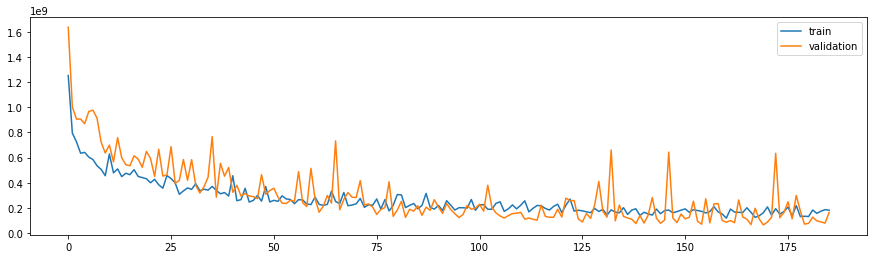

In [24]:
# plot the loss and accuracy
fig, ax = plt.subplots(figsize=(15, 4))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.savefig('./model_dnn/loss.png', facecolor='white', dpi=300)
plt.show()
plt.close()

57/57 [==============================] - 0s 1ms/step


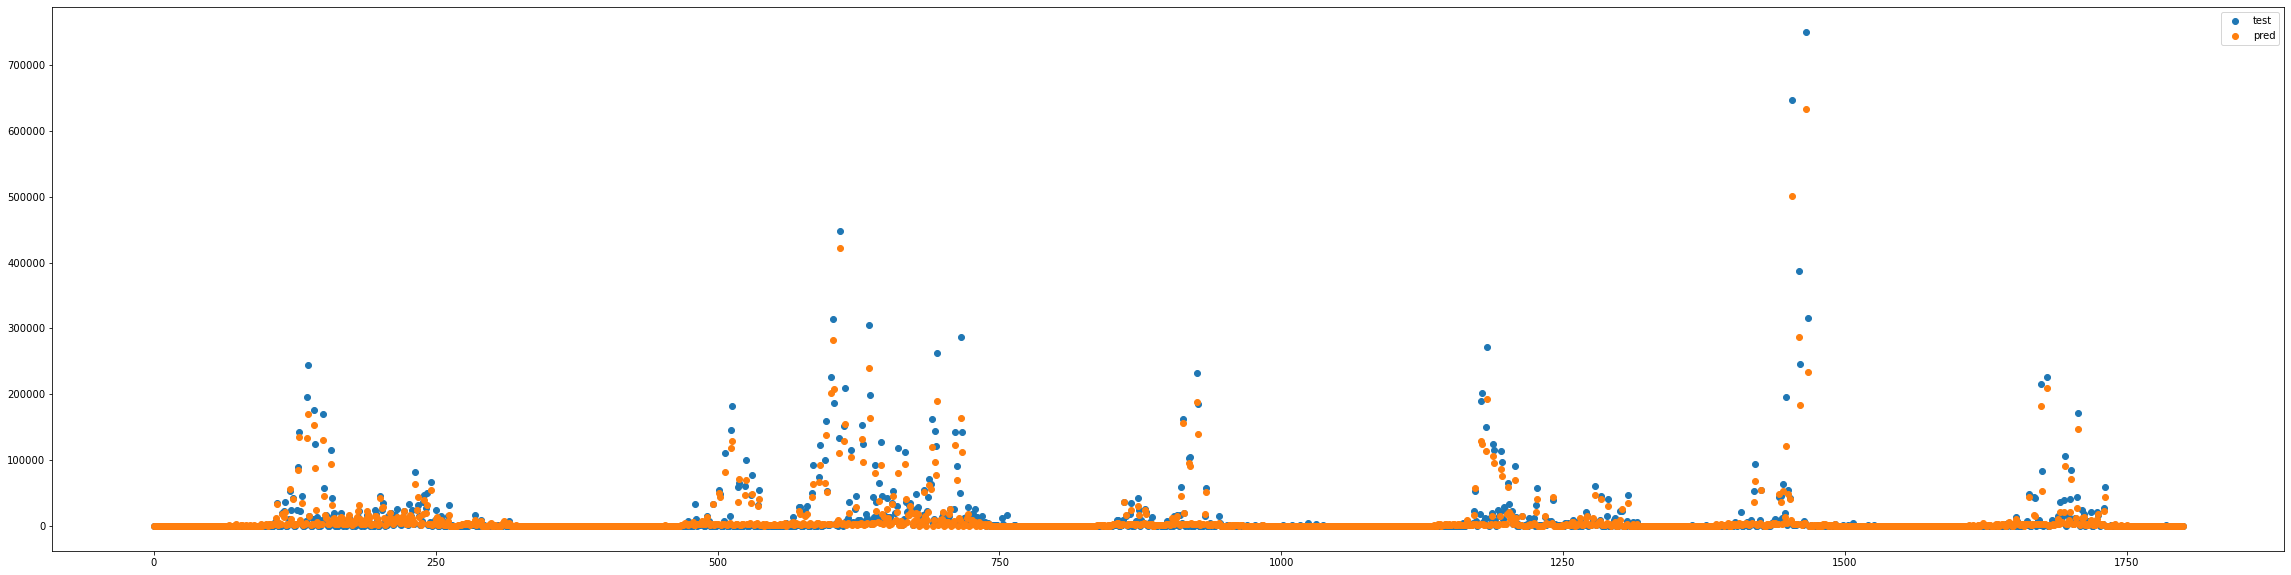

In [25]:
# plot test data with prediction values with legend.
y_pred = model.predict(X_test)

fig, ax = plt.subplots(figsize=(40, 10))
plt.plot(y_test, 'o', label='test')
plt.plot(y_pred, 'o', label='pred')
plt.legend()
plt.show()

In [26]:
input_cols

Index(['평균기온', '최저기온', '최고기온', '일강수량', '최대풍속', '평균풍속', '수위_DAY', '유량_DAY',
       '수온', '용존산소', '총유기탄소', '클로로필', '보방류량_DAY', '보유입량_DAY', '보저수량_DAY',
       '보저수위_DAY', '수온_WEK', 'pH_WEK', 'DO_WEK', 'Chl-a _WEK'],
      dtype='object')

            % of NaN
평균기온        3.409869
최저기온        3.409869
최고기온        3.409869
일강수량        3.409869
최대풍속        3.409869
평균풍속        3.409869
수위_DAY      0.000000
유량_DAY      0.000000
수온          0.121337
용존산소        0.205339
총유기탄소       0.395122
클로로필        0.242673
보방류량_DAY    0.127559
보유입량_DAY    0.127559
보저수량_DAY    0.000000
보저수위_DAY    0.000000
수온_WEK      0.049779
pH_WEK      0.049779
DO_WEK      0.049779
투명도_WEK     0.049779
탁도_WEK      0.049779
Chl-a _WEK  0.049779
유해남조류세포수    0.071557 
 (1096, 23)
(1096, 20)
(0, 20)
./POST_DATA\낙동강_강정고령.csv
            % of NaN
평균기온        3.409869
최저기온        3.409869
최고기온        3.409869
일강수량        3.409869
최대풍속        3.409869
평균풍속        3.409869
수위_DAY      0.000000
유량_DAY      0.000000
수온          0.121337
용존산소        0.205339
총유기탄소       0.395122
클로로필        0.242673
보방류량_DAY    0.127559
보유입량_DAY    0.127559
보저수량_DAY    0.000000
보저수위_DAY    0.000000
수온_WEK      0.018667
pH_WEK      0.018667
DO_WEK      0.018667
투명도_WEK     1.51826

C:\Users\ympark\AppData\Local\Temp\ipykernel_32376\1129804281.py:87: UserWarning: Glyph 45209 (\N{HANGUL SYLLABLE NAG}) missing from current font.
  plt.savefig('./model_dnn/{}.png'.format(point_name), facecolor='white', dpi=300)
C:\Users\ympark\AppData\Local\Temp\ipykernel_32376\1129804281.py:87: UserWarning: Glyph 46041 (\N{HANGUL SYLLABLE DONG}) missing from current font.
  plt.savefig('./model_dnn/{}.png'.format(point_name), facecolor='white', dpi=300)
C:\Users\ympark\AppData\Local\Temp\ipykernel_32376\1129804281.py:87: UserWarning: Glyph 44053 (\N{HANGUL SYLLABLE GANG}) missing from current font.
  plt.savefig('./model_dnn/{}.png'.format(point_name), facecolor='white', dpi=300)
C:\Users\ympark\AppData\Local\Temp\ipykernel_32376\1129804281.py:87: UserWarning: Glyph 44396 (\N{HANGUL SYLLABLE GU}) missing from current font.
  plt.savefig('./model_dnn/{}.png'.format(point_name), facecolor='white', dpi=300)
C:\Users\ympark\AppData\Local\Temp\ipykernel_32376\1129804281.py:87: UserWarnin

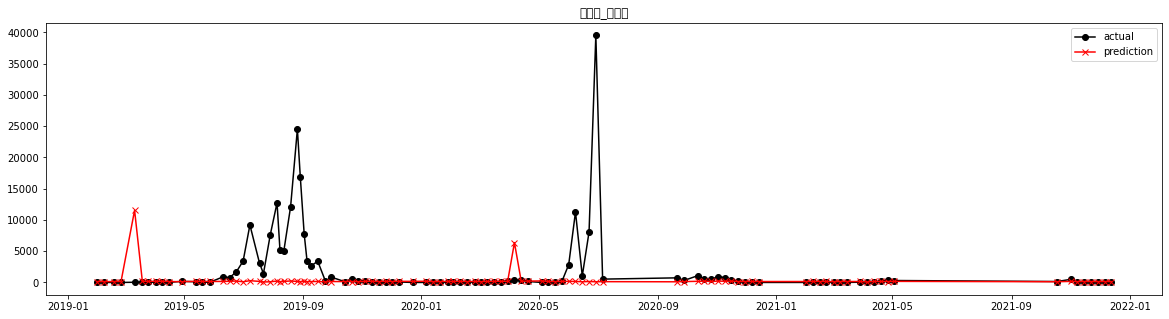

            % of NaN
평균기온        0.000000
최저기온        0.000000
최고기온        0.000000
일강수량        0.000000
최대풍속        0.000000
평균풍속        0.000000
수위_DAY      0.000000
유량_DAY      0.000000
수온          0.149337
용존산소        0.273785
총유기탄소       0.743575
클로로필        0.569349
보방류량_DAY    0.071557
보유입량_DAY    0.071557
보저수량_DAY    0.000000
보저수위_DAY    0.000000
수온_WEK      0.189783
pH_WEK      0.189783
DO_WEK      0.189783
투명도_WEK     1.627155
탁도_WEK      1.627155
Chl-a _WEK  0.189783
유해남조류세포수    0.211561 
 (1096, 23)
(1096, 20)
(84, 20)
3/3 [==============================] - 0s 1ms/step


C:\Users\ympark\AppData\Local\Temp\ipykernel_32376\1129804281.py:87: UserWarning: Glyph 45209 (\N{HANGUL SYLLABLE NAG}) missing from current font.
  plt.savefig('./model_dnn/{}.png'.format(point_name), facecolor='white', dpi=300)
C:\Users\ympark\AppData\Local\Temp\ipykernel_32376\1129804281.py:87: UserWarning: Glyph 46041 (\N{HANGUL SYLLABLE DONG}) missing from current font.
  plt.savefig('./model_dnn/{}.png'.format(point_name), facecolor='white', dpi=300)
C:\Users\ympark\AppData\Local\Temp\ipykernel_32376\1129804281.py:87: UserWarning: Glyph 44053 (\N{HANGUL SYLLABLE GANG}) missing from current font.
  plt.savefig('./model_dnn/{}.png'.format(point_name), facecolor='white', dpi=300)
C:\Users\ympark\AppData\Local\Temp\ipykernel_32376\1129804281.py:87: UserWarning: Glyph 45800 (\N{HANGUL SYLLABLE DAN}) missing from current font.
  plt.savefig('./model_dnn/{}.png'.format(point_name), facecolor='white', dpi=300)
C:\Users\ympark\AppData\Local\Temp\ipykernel_32376\1129804281.py:87: UserWarni

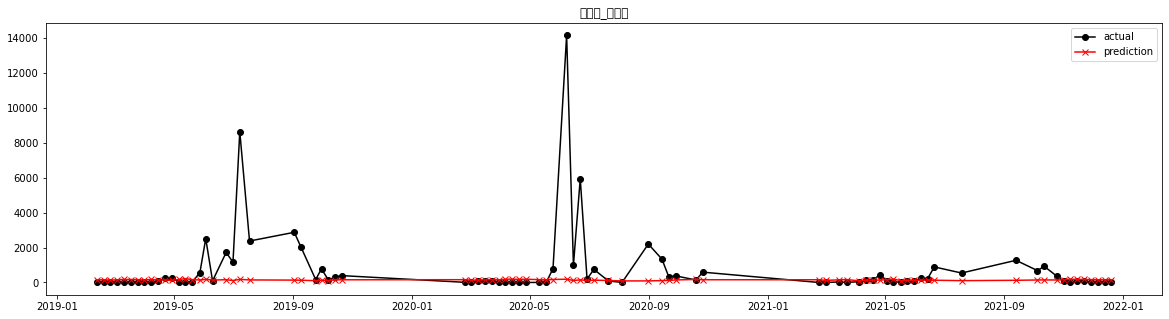

            % of NaN
평균기온        3.409869
최저기온        3.409869
최고기온        3.409869
일강수량        3.409869
최대풍속        3.409869
평균풍속        3.409869
수위_DAY      0.000000
유량_DAY      0.000000
수온          0.696907
용존산소        0.784021
총유기탄소       0.914691
클로로필        0.827578
보방류량_DAY    0.146226
보유입량_DAY    0.146226
보저수량_DAY    0.000000
보저수위_DAY    0.000000
수온_WEK      0.000000
pH_WEK      0.000000
DO_WEK      0.000000
투명도_WEK     1.499596
탁도_WEK      1.499596
Chl-a _WEK  0.000000
유해남조류세포수    0.000000 
 (1096, 23)
(1096, 20)
(0, 20)
./POST_DATA\낙동강_달성보.csv
            % of NaN
평균기온        0.003111
최저기온        0.000000
최고기온        0.000000
일강수량        0.000000
최대풍속        0.003111
평균풍속        0.000000
수위_DAY      0.000000
유량_DAY      0.000000
수온          0.093336
용존산소        0.314231
총유기탄소       0.743575
클로로필        0.099558
보방류량_DAY    0.196005
보유입량_DAY    0.199116
보저수량_DAY    0.000000
보저수위_DAY    0.000000
수온_WEK      1.499596
pH_WEK      1.499596
DO_WEK      1.499596
투명도_WEK     1.499596

C:\Users\ympark\AppData\Local\Temp\ipykernel_32376\1129804281.py:87: UserWarning: Glyph 45209 (\N{HANGUL SYLLABLE NAG}) missing from current font.
  plt.savefig('./model_dnn/{}.png'.format(point_name), facecolor='white', dpi=300)
C:\Users\ympark\AppData\Local\Temp\ipykernel_32376\1129804281.py:87: UserWarning: Glyph 46041 (\N{HANGUL SYLLABLE DONG}) missing from current font.
  plt.savefig('./model_dnn/{}.png'.format(point_name), facecolor='white', dpi=300)
C:\Users\ympark\AppData\Local\Temp\ipykernel_32376\1129804281.py:87: UserWarning: Glyph 44053 (\N{HANGUL SYLLABLE GANG}) missing from current font.
  plt.savefig('./model_dnn/{}.png'.format(point_name), facecolor='white', dpi=300)
C:\Users\ympark\AppData\Local\Temp\ipykernel_32376\1129804281.py:87: UserWarning: Glyph 47932 (\N{HANGUL SYLLABLE MUL}) missing from current font.
  plt.savefig('./model_dnn/{}.png'.format(point_name), facecolor='white', dpi=300)
C:\Users\ympark\AppData\Local\Temp\ipykernel_32376\1129804281.py:87: UserWarni

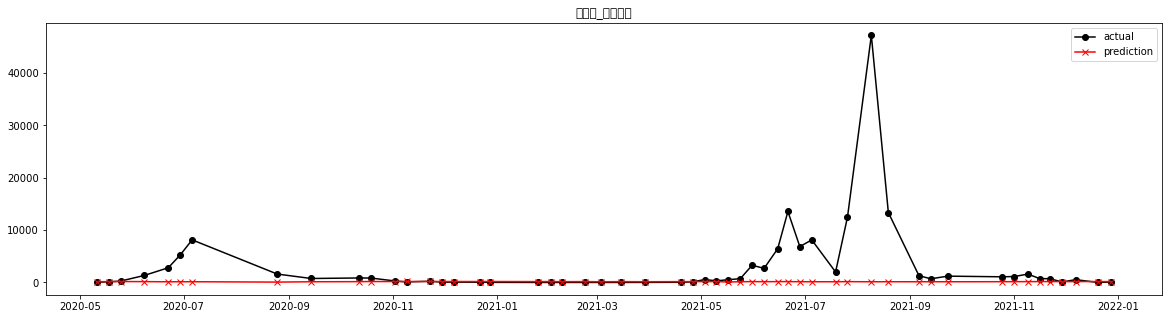

            % of NaN
평균기온        0.000000
최저기온        0.000000
최고기온        0.000000
일강수량        0.000000
최대풍속        0.000000
평균풍속        0.000000
수위_DAY      0.000000
유량_DAY      0.000000
수온          0.479124
용존산소        0.572460
총유기탄소       0.612905
클로로필        0.510236
보방류량_DAY    0.074669
보유입량_DAY    0.077780
보저수량_DAY    0.000000
보저수위_DAY    0.000000
수온_WEK      0.233340
pH_WEK      0.233340
DO_WEK      0.233340
투명도_WEK     1.627155
탁도_WEK      1.627155
Chl-a _WEK  0.233340
유해남조류세포수    0.233340 
 (1096, 23)
(1096, 20)
(106, 20)
4/4 [==============================] - 0s 1ms/step


C:\Users\ympark\AppData\Local\Temp\ipykernel_32376\1129804281.py:87: UserWarning: Glyph 45209 (\N{HANGUL SYLLABLE NAG}) missing from current font.
  plt.savefig('./model_dnn/{}.png'.format(point_name), facecolor='white', dpi=300)
C:\Users\ympark\AppData\Local\Temp\ipykernel_32376\1129804281.py:87: UserWarning: Glyph 46041 (\N{HANGUL SYLLABLE DONG}) missing from current font.
  plt.savefig('./model_dnn/{}.png'.format(point_name), facecolor='white', dpi=300)
C:\Users\ympark\AppData\Local\Temp\ipykernel_32376\1129804281.py:87: UserWarning: Glyph 44053 (\N{HANGUL SYLLABLE GANG}) missing from current font.
  plt.savefig('./model_dnn/{}.png'.format(point_name), facecolor='white', dpi=300)
C:\Users\ympark\AppData\Local\Temp\ipykernel_32376\1129804281.py:87: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from current font.
  plt.savefig('./model_dnn/{}.png'.format(point_name), facecolor='white', dpi=300)
C:\Users\ympark\AppData\Local\Temp\ipykernel_32376\1129804281.py:87: UserWarn

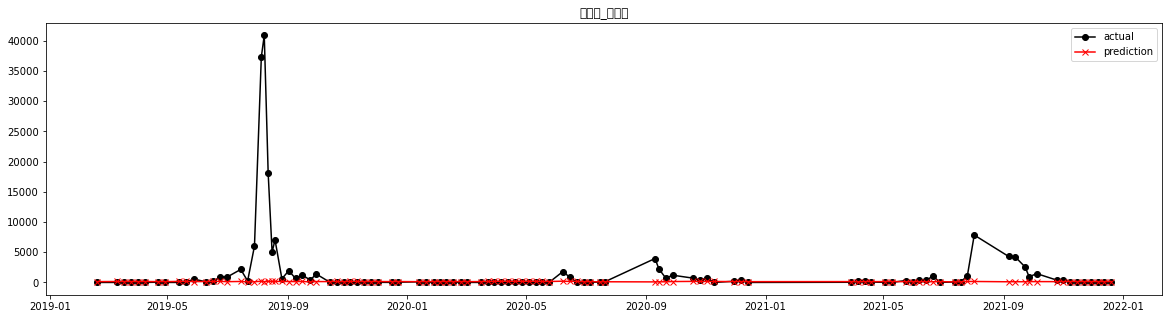

            % of NaN
평균기온        0.018667
최저기온        0.000000
최고기온        0.000000
일강수량        0.000000
최대풍속        0.028001
평균풍속        0.037334
수위_DAY      0.000000
유량_DAY      0.000000
수온          0.423122
용존산소        0.507125
총유기탄소       0.619128
클로로필        0.566237
보방류량_DAY    0.196005
보유입량_DAY    0.199116
보저수량_DAY    0.000000
보저수위_DAY    0.000000
수온_WEK      0.000000
pH_WEK      0.000000
DO_WEK      0.000000
투명도_WEK     1.499596
탁도_WEK      1.499596
Chl-a _WEK  0.000000
유해남조류세포수    0.000000 
 (1096, 23)
(1096, 20)
(93, 20)
3/3 [==============================] - 0s 1ms/step


C:\Users\ympark\AppData\Local\Temp\ipykernel_32376\1129804281.py:87: UserWarning: Glyph 45209 (\N{HANGUL SYLLABLE NAG}) missing from current font.
  plt.savefig('./model_dnn/{}.png'.format(point_name), facecolor='white', dpi=300)
C:\Users\ympark\AppData\Local\Temp\ipykernel_32376\1129804281.py:87: UserWarning: Glyph 46041 (\N{HANGUL SYLLABLE DONG}) missing from current font.
  plt.savefig('./model_dnn/{}.png'.format(point_name), facecolor='white', dpi=300)
C:\Users\ympark\AppData\Local\Temp\ipykernel_32376\1129804281.py:87: UserWarning: Glyph 44053 (\N{HANGUL SYLLABLE GANG}) missing from current font.
  plt.savefig('./model_dnn/{}.png'.format(point_name), facecolor='white', dpi=300)
C:\Users\ympark\AppData\Local\Temp\ipykernel_32376\1129804281.py:87: UserWarning: Glyph 52285 (\N{HANGUL SYLLABLE CANG}) missing from current font.
  plt.savefig('./model_dnn/{}.png'.format(point_name), facecolor='white', dpi=300)
C:\Users\ympark\AppData\Local\Temp\ipykernel_32376\1129804281.py:87: UserWarn

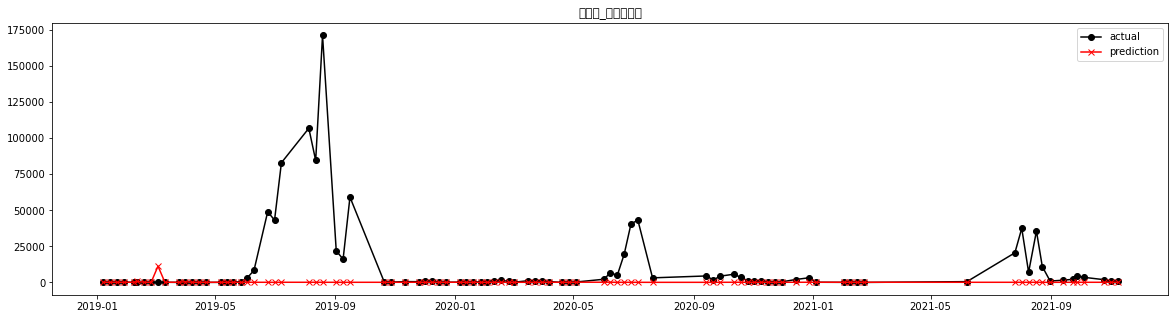

            % of NaN
평균기온        0.003111
최저기온        0.000000
최고기온        0.000000
일강수량        0.000000
최대풍속        0.003111
평균풍속        0.000000
수위_DAY      0.000000
유량_DAY      0.000000
수온          0.217784
용존산소        0.329787
총유기탄소       0.491569
클로로필        0.283119
보방류량_DAY    0.127559
보유입량_DAY    0.127559
보저수량_DAY    0.000000
보저수위_DAY    0.000000
수온_WEK      0.018667
pH_WEK      0.018667
DO_WEK      0.018667
투명도_WEK     1.518263
탁도_WEK      1.518263
Chl-a _WEK  0.018667
유해남조류세포수    0.037334 
 (1096, 23)
(1096, 20)
(114, 20)
4/4 [==============================] - 0s 1ms/step


C:\Users\ympark\AppData\Local\Temp\ipykernel_32376\1129804281.py:87: UserWarning: Glyph 45209 (\N{HANGUL SYLLABLE NAG}) missing from current font.
  plt.savefig('./model_dnn/{}.png'.format(point_name), facecolor='white', dpi=300)
C:\Users\ympark\AppData\Local\Temp\ipykernel_32376\1129804281.py:87: UserWarning: Glyph 46041 (\N{HANGUL SYLLABLE DONG}) missing from current font.
  plt.savefig('./model_dnn/{}.png'.format(point_name), facecolor='white', dpi=300)
C:\Users\ympark\AppData\Local\Temp\ipykernel_32376\1129804281.py:87: UserWarning: Glyph 44053 (\N{HANGUL SYLLABLE GANG}) missing from current font.
  plt.savefig('./model_dnn/{}.png'.format(point_name), facecolor='white', dpi=300)
C:\Users\ympark\AppData\Local\Temp\ipykernel_32376\1129804281.py:87: UserWarning: Glyph 52832 (\N{HANGUL SYLLABLE CIL}) missing from current font.
  plt.savefig('./model_dnn/{}.png'.format(point_name), facecolor='white', dpi=300)
C:\Users\ympark\AppData\Local\Temp\ipykernel_32376\1129804281.py:87: UserWarni

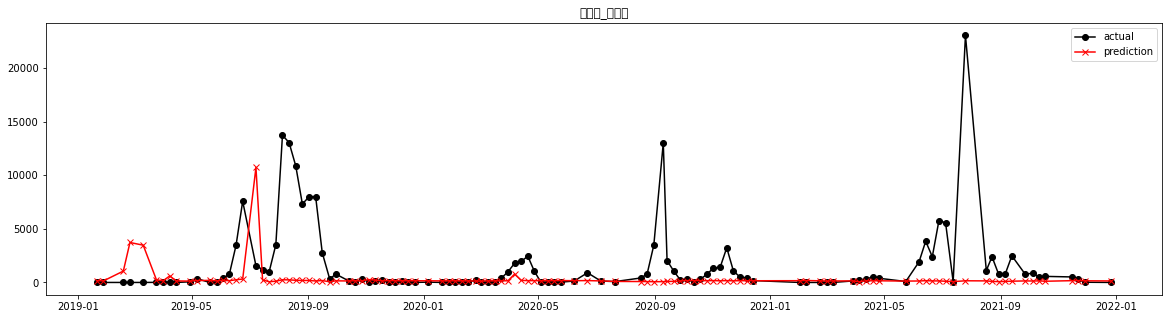

          % of NaN
평균기온      0.018667
최저기온      0.000000
최저기온시각    0.000000
최고기온      0.000000
일강수량      2.296061
...            ...
DO        2.905855
투명도       2.905855
탁도.1      2.905855
Chl-a     2.905855
유해남조류세포수  0.000000

[139 rows x 1 columns] 
 (1096, 139)
./POST_DATA\낙동강_칠서.csv
            % of NaN
평균기온        0.012445
최저기온        0.012445
최고기온        0.009334
일강수량        0.000000
최대풍속        0.018667
평균풍속        0.018667
수위_DAY      0.000000
유량_DAY      0.000000
수온          0.295563
용존산소        0.404455
총유기탄소       0.603572
클로로필        0.292452
보방류량_DAY    0.000000
보유입량_DAY    0.000000
보저수량_DAY    0.000000
보저수위_DAY    0.000000
수온_WEK      0.000000
pH_WEK      0.000000
DO_WEK      0.000000
투명도_WEK     1.499596
탁도_WEK      1.499596
Chl-a _WEK  0.000000
유해남조류세포수    0.000000 
 (1096, 23)
(1096, 20)
(129, 20)
5/5 [==============================] - 0s 1ms/step


C:\Users\ympark\AppData\Local\Temp\ipykernel_32376\1129804281.py:87: UserWarning: Glyph 45209 (\N{HANGUL SYLLABLE NAG}) missing from current font.
  plt.savefig('./model_dnn/{}.png'.format(point_name), facecolor='white', dpi=300)
C:\Users\ympark\AppData\Local\Temp\ipykernel_32376\1129804281.py:87: UserWarning: Glyph 46041 (\N{HANGUL SYLLABLE DONG}) missing from current font.
  plt.savefig('./model_dnn/{}.png'.format(point_name), facecolor='white', dpi=300)
C:\Users\ympark\AppData\Local\Temp\ipykernel_32376\1129804281.py:87: UserWarning: Glyph 44053 (\N{HANGUL SYLLABLE GANG}) missing from current font.
  plt.savefig('./model_dnn/{}.png'.format(point_name), facecolor='white', dpi=300)
C:\Users\ympark\AppData\Local\Temp\ipykernel_32376\1129804281.py:87: UserWarning: Glyph 54633 (\N{HANGUL SYLLABLE HAB}) missing from current font.
  plt.savefig('./model_dnn/{}.png'.format(point_name), facecolor='white', dpi=300)
C:\Users\ympark\AppData\Local\Temp\ipykernel_32376\1129804281.py:87: UserWarni

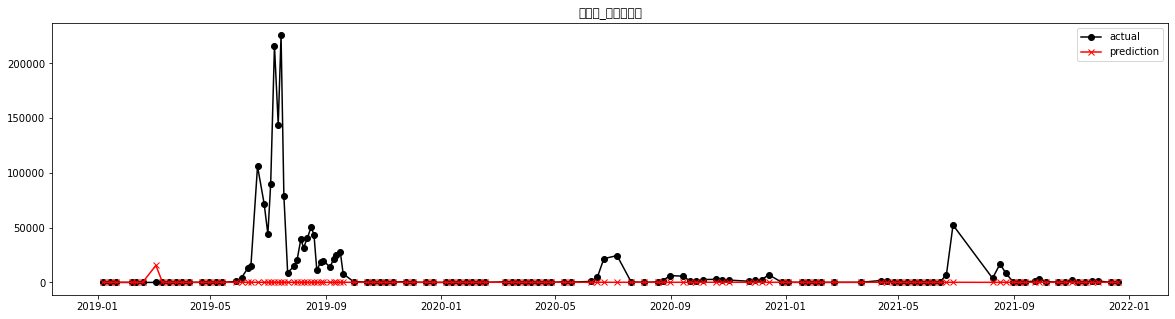

            % of NaN
평균기온        0.003111
최저기온        0.000000
최고기온        0.000000
일강수량        0.000000
최대풍속        0.003111
평균풍속        0.000000
수위_DAY      0.000000
유량_DAY      0.000000
수온          0.354676
용존산소        0.385788
총유기탄소       0.808910
클로로필        1.020472
보방류량_DAY    0.096447
보유입량_DAY    0.096447
보저수량_DAY    0.000000
보저수위_DAY    0.000000
수온_WEK      0.133781
pH_WEK      0.133781
DO_WEK      0.133781
투명도_WEK     0.133781
탁도_WEK      0.133781
Chl-a _WEK  0.133781
유해남조류세포수    0.155560 
 (1096, 23)
(1096, 20)
(79, 20)
3/3 [==============================] - 0s 1ms/step


C:\Users\ympark\AppData\Local\Temp\ipykernel_32376\1129804281.py:87: UserWarning: Glyph 45209 (\N{HANGUL SYLLABLE NAG}) missing from current font.
  plt.savefig('./model_dnn/{}.png'.format(point_name), facecolor='white', dpi=300)
C:\Users\ympark\AppData\Local\Temp\ipykernel_32376\1129804281.py:87: UserWarning: Glyph 46041 (\N{HANGUL SYLLABLE DONG}) missing from current font.
  plt.savefig('./model_dnn/{}.png'.format(point_name), facecolor='white', dpi=300)
C:\Users\ympark\AppData\Local\Temp\ipykernel_32376\1129804281.py:87: UserWarning: Glyph 44053 (\N{HANGUL SYLLABLE GANG}) missing from current font.
  plt.savefig('./model_dnn/{}.png'.format(point_name), facecolor='white', dpi=300)
C:\Users\ympark\AppData\Local\Temp\ipykernel_32376\1129804281.py:87: UserWarning: Glyph 54644 (\N{HANGUL SYLLABLE HAE}) missing from current font.
  plt.savefig('./model_dnn/{}.png'.format(point_name), facecolor='white', dpi=300)
C:\Users\ympark\AppData\Local\Temp\ipykernel_32376\1129804281.py:87: UserWarni

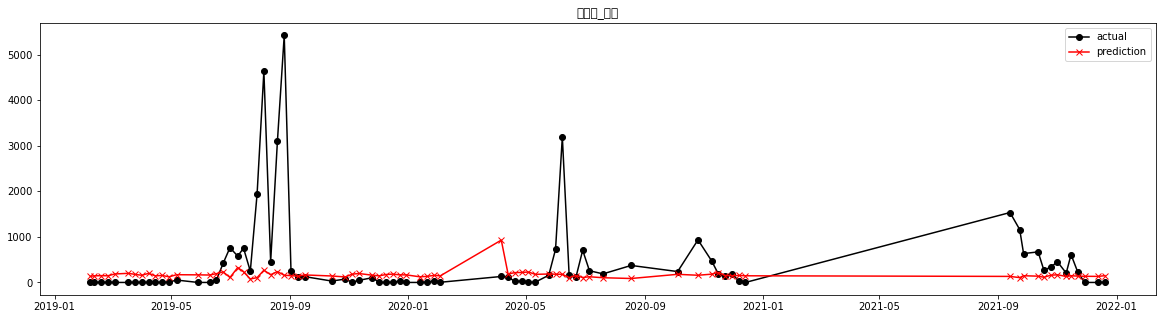

In [28]:
# read post_datas
post_list = glob.glob('./POST_DATA/낙동강*.csv')

for post_path in post_list:

    try:
        point_name = post_path.split('\\')[-1].split('.')[0]
        # read test point data
        test_point_raw = pd.read_csv(post_path, encoding='cp949', index_col=0, parse_dates=True)

        # # slice period over 2023-01-01
        test_point_raw = test_point_raw.loc['2019-01-01':'2021-12-31']

        use_index = test_point_raw['유해남조류세포수'].dropna(axis=0).index

        # interpolate nan values in '유해남조류세포수'
        test_point_raw['유해남조류세포수'] = test_point_raw['유해남조류세포수'].interpolate(method='linear', limit=14, limit_direction='both')

        # # apply log scale to '유해남조류세포수'
        # test_point_raw['유해남조류세포수'] = np.log(test_point_raw['유해남조류세포수'])

        # # fill nan values or -inf values with 0 in '유해남조류세포수'
        # test_point_raw['유해남조류세포수'] = test_point_raw['유해남조류세포수'].replace(-np.inf, 0)

        # calculte % of nan values in each columns of data
        nan_df = pd.DataFrame(test_point_raw.isnull().sum()/len(data)*100, columns=['% of NaN'])
        print(nan_df, '\n',test_point_raw.shape)

        # make target column
        test_point_raw['유해남조류세포수_Y'] = test_point_raw['유해남조류세포수'].shift(-1)


        test_point = test_point_raw.copy()
        test_point = test_point[input_cols]

        # test_point = test_point.interpolate(method='linear')

        print(test_point.shape)

        test_cols = test_point.columns
        test_indx = test_point.index

        # apply scaler 
        test_scaled = scaler.transform(test_point)

        test_scaled = pd.DataFrame(test_scaled, columns=test_cols, index=test_indx)

        # apply create_dataset function to test point data
        test_point = test_point.loc[use_index]
        test_point = test_point.dropna(axis=0)
        print(test_point.shape)

        # reshape test point data
        test_point_input = test_point.values

        # predict
        test_point_pred = model.predict(test_point_input)
        test_result = pd.DataFrame(test_point_pred, index=test_point.index, columns=['prediction'])
        rawd_result = test_point_raw.loc[test_point.index, ['유해남조류세포수_Y']]

        # # # inverse log
        # test_result['prediction_inv'] = test_result['prediction'].apply(lambda x: np.exp(x))
        # rawd_result['유해남조류세포수_Y_inv'] = rawd_result['유해남조류세포수_Y'].apply(lambda x: np.exp(x))

        # concat prediction and actual data
        test_result = pd.concat([test_result, rawd_result], axis=1)
        # save prediction and actual data
        test_result.to_csv('./model_dnn/{}.csv'.format(point_name), encoding='cp949')

        # # plot the prediction
        # fig, ax = plt.subplots(figsize=(20, 5))
        # # ax.set_facecolor('white')
        # plt.plot(test_result['유해남조류세포수_Y_inv'], 'ko-', label='actual')
        # plt.plot(test_result['prediction_inv'], 'ro-', label='prediction')
        # plt.title(point_name)
        # plt.legend()

        # plt.savefig('./model_attn/result/{}_log.png'.format(point_name), facecolor='white', dpi=300)

        fig, ax = plt.subplots(figsize=(20, 5))
        # ax.set_facecolor('white')
        plt.plot(test_result['유해남조류세포수_Y'], 'ko-', label='actual')
        plt.plot(test_result['prediction'], 'rx-', label='prediction')
        plt.title(point_name)
        plt.legend()
        # plt.yscale('log')
        plt.savefig('./model_dnn/{}.png'.format(point_name), facecolor='white', dpi=300)
        

        plt.show()
        plt.close()
    except:
        print(post_path)
        pass